In [1]:
%reset
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.ticker as mticker
import warnings; warnings.filterwarnings('ignore')
import cmocean

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [2]:
%cd /glade/p/univ/unyu0004/neerajab/NeverWorld2/
run=20 #1/4 degree NeverWorld setup
#run=26 #1/8 degree NeverWorld setup
#run=28 #1/8 degree NeverWorld setup
fs=xr.open_dataset('run%i/static.nc' % (run), decode_times=False)
os=xr.open_dataset('run%i/ocean.stats.nc' % (run), decode_times=False)
forcing=xr.open_dataset('run%i/forcing_00000500.nc' % (run), decode_times=False)
tau = 500*86400
end_time = 30500
start_time = end_time - tau/86400

sn     = xr.open_dataset('run%i/snapshots_000%i.nc' % (run, end_time-500+5), decode_times=False) #snapshot
av     = xr.open_dataset('run%i/averages_000%i.nc' % (run, end_time-500+2), decode_times=False)  #5-day average
%cd /glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis/

/glade/p/univ/unyu0004/neerajab/NeverWorld2
/glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis


In [3]:
#Read in various grid variables from the static file and forcing:
lon=fs['geolon']; lat=fs['geolat']
lonc=fs['geolon_c']; latc=fs['geolat_c']
lonu=fs['geolon_u']; latu=fs['geolat_u']
lonv=fs['geolon_v']; latv=fs['geolat_v']
depth = fs['depth_ocean']
dxCu = fs['dxCu']; dyCv = fs['dyCv']; 
dx = (np.array(dxCu[:,:-1])+np.array(dxCu[:,1:]))*0.5
dy = (np.array(dyCv[1:,:])+np.array(dyCv[:-1,:]))*0.5

xh = fs.xh.values
yh = fs.yh.values
xq = fs.xq.values
yq = fs.yq.values

taux= forcing.taux.values[0,:,:]; taux=(taux[:,1:]+taux[:,:-1])/2.
taux.shape

(560, 240)

In [2]:
# #Plotting ocean depth
# fig = plt.figure(figsize=(4, 7), dpi= 80, facecolor='w', edgecolor='k')
# ax1 = fig.add_axes([0.15,0.2,0.6,0.7]) 
# ax2 = fig.add_axes([.78, 0.2, 0.03, 0.7])
# ax1.set_facecolor((0.92, 0.92, 0.92))
# ax1.set_title('Ocean depth (m)',fontsize=20)
# ax1.set_xlabel('Longitude',fontsize=16)
# ax1.set_ylabel('Latitude',fontsize=16)
# ax1.tick_params(labelsize=16); 
# ax2.tick_params(labelsize=14)

# plotted =ax1.pcolor(xh,yh,depth,cmap=cmocean.cm.turbid)
# ax1.set_aspect('equal', 'box')
# cbar = plt.colorbar(mappable=plotted, cax=ax2, orientation = 'vertical');
# cbar.ax.tick_params(labelsize=14);
# #
# plt.show()
# #fig.savefig('topography.png')

In [3]:
# #Plotting zonal wind forcing (taux)
# fig = plt.figure(figsize=(4, 7), dpi=80, facecolor='w', edgecolor='k')
# ax1 = fig.add_axes([0.15,0.2,0.6,0.7]) 
# ax2 = fig.add_axes([.78, 0.2, 0.03, 0.7])
# ax1.set_facecolor((0.92, 0.92, 0.92))
# ax1.set_title('Zonal Wind Stress (Pa)',fontsize=20)
# ax1.set_xlabel('Longitude',fontsize=16)
# ax1.set_ylabel('Latitude',fontsize=16)
# ax1.tick_params(labelsize=16); 
# ax2.tick_params(labelsize=14)

# plotted =ax1.pcolor(xh,yh,taux,cmap='RdBu_r',vmin=-0.2,vmax=0.2)
# ax1.set_aspect('equal', 'box')
# cbar = plt.colorbar(mappable=plotted, cax=ax2, orientation = 'vertical');
# cbar.ax.tick_params(labelsize=14);
# #
# plt.show()
# #fig.savefig('taux.png')

In [109]:
#time averaged quantities -- 100 days
u  = np.nanmean(np.array(av['u'][:,:,:]),axis=0); u = 0.5*(u[:,:,1:]+u[:,:,:-1]) 
v  = np.nanmean(np.array(av['v'][:,:,:]),axis=0); v = 0.5*(v[:,1:,:]+v[:,:-1,:]) 
Rd1= np.nanmean(np.array(av['Rd1'][:,:,:]),axis=0); 
Rd_dx=np.nanmean(np.array(av['Rd_dx'][:,:,:]),axis=0); 
KE = 0.5*(u**2+v**2)
KE.shape
h = np.nanmean(np.array(av['h'][:,:,:]),axis=0);

Layer = np.array(os['Layer']);
eta = np.zeros((len(Layer)+1,len(yh),len(xh)));
for i in range(1,len(Layer)+1):
    eta[i,:,:]=np.nansum(h[0:i,:,:],axis=0)    
#To make sure eta is correct: #print(eta[:,50]); print(h[:,50])    

In [110]:
weighted_KE_mean=np.tile((np.nansum(h*KE,axis=0)/np.nansum(h,axis=0)),[100,1,1])
weighted_KE_mean.shape

(100, 2240, 960)

In [111]:
#time averaged quantities -- 5 days
u_short  = np.array(av['u'][:,:,:]); u_short = 0.5*(u_short[:,:,:,1:]+u_short[:,:,:,:-1]) 
v_short  = np.array(av['v'][:,:,:]); v_short = 0.5*(v_short[:,:,1:,:]+v_short[:,:,:-1,:]) 
h_short  = np.array(av['h'][:,:,:]);
Rd1=  np.array(av['Rd1'][:,:,:]); 
Rd_dx=np.array(av['Rd_dx'][:,:,:]); 
KE_short = 0.5*(u_short**2+v_short**2)
weighted_KE_short=(np.nansum(h_short*KE_short,axis=1)/np.nansum(h_short,axis=1))
EKE_mean=np.nanmean(abs(weighted_KE_short-weighted_KE_mean),axis=0)

In [112]:
EKE_mean.shape

(2240, 960)

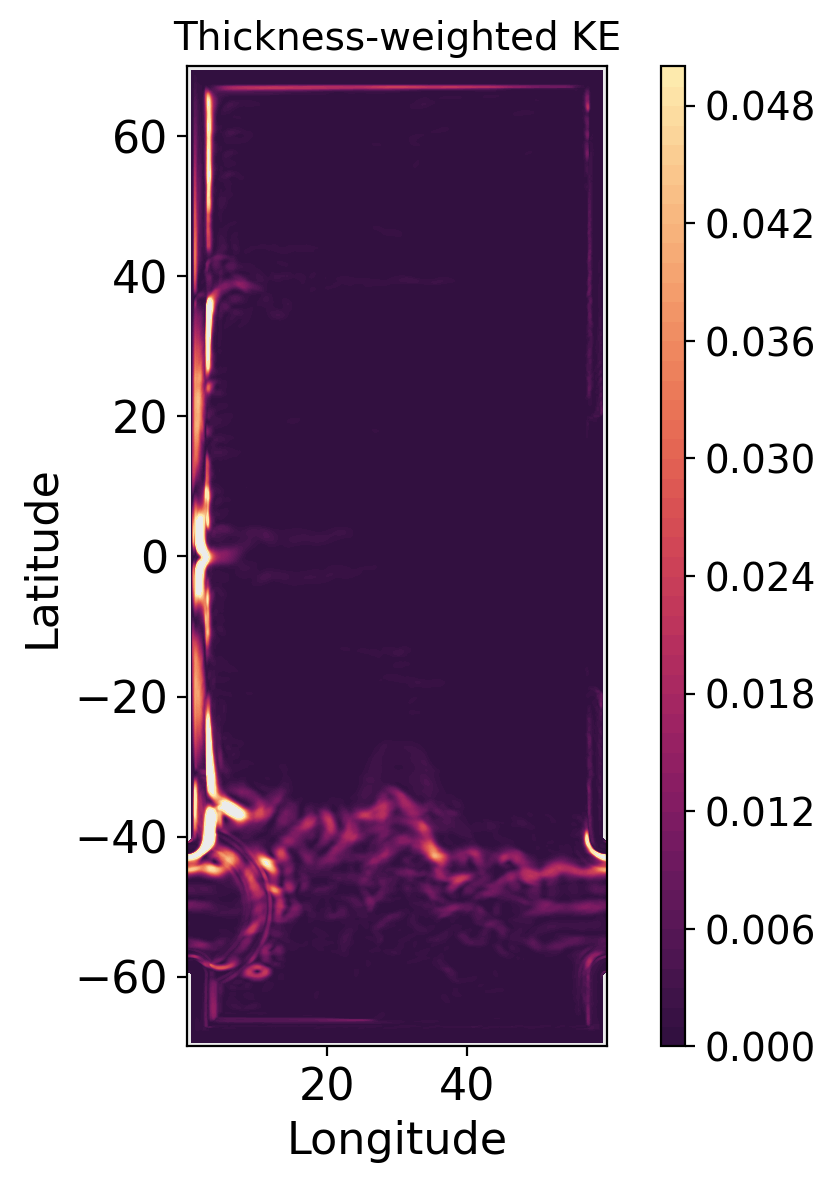

In [113]:
#Plotting KE 
fig = plt.figure(figsize=(4, 7), dpi=200, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.6,0.7]) 
ax2 = fig.add_axes([.78, 0.2, 0.03, 0.7])
ax1.set_facecolor((0.92, 0.92, 0.92))
ax1.set_title('Thickness-weighted KE',fontsize=14)
ax1.set_xlabel('Longitude',fontsize=16)
ax1.set_ylabel('Latitude',fontsize=16)
ax1.tick_params(labelsize=16); 
ax2.tick_params(labelsize=14)

plotted =ax1.contourf(xh,yh,np.nanmean(weighted_KE_mean,axis=0),levels=np.linspace(0.,.05,51),cmap=cmocean.cm.matter_r)

ax1.set_aspect('equal', 'box')
cbar = plt.colorbar(mappable=plotted, cax=ax2, orientation = 'vertical');
cbar.ax.tick_params(labelsize=14);
#
plt.show()

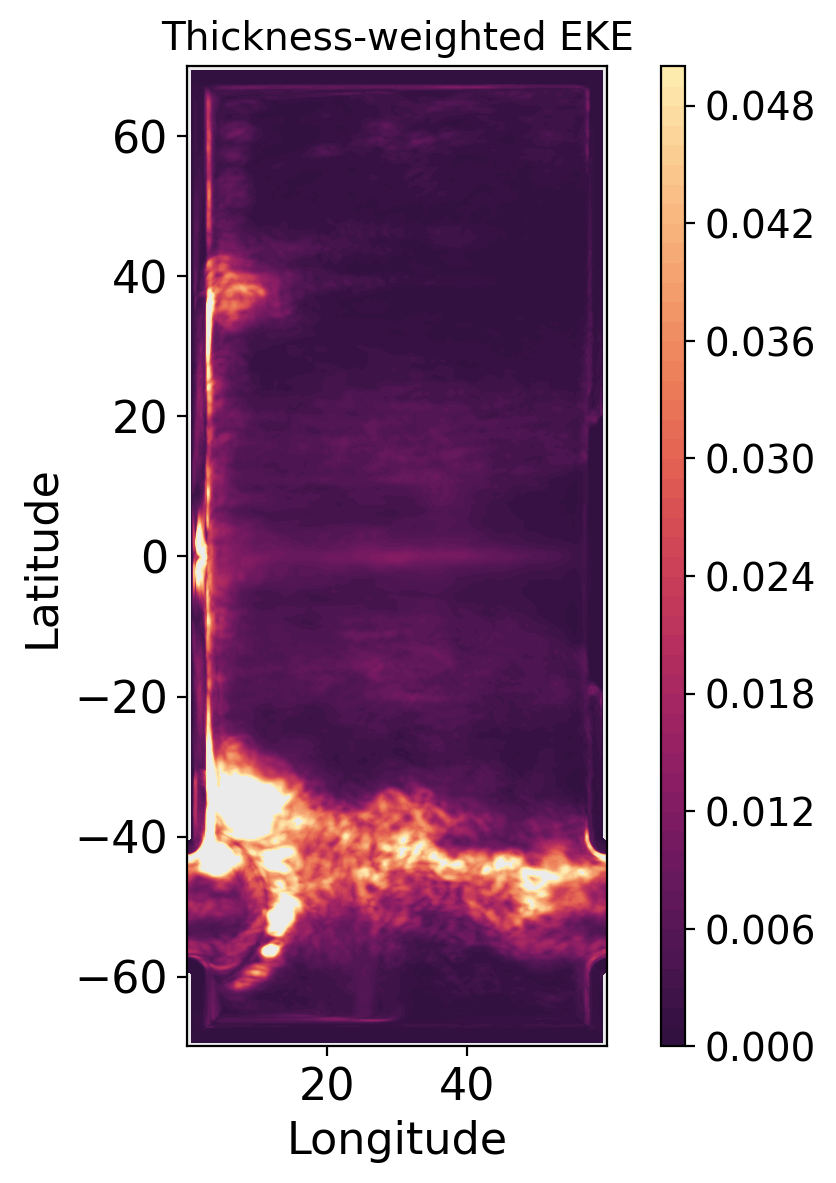

In [114]:
#Plotting EKE 
fig = plt.figure(figsize=(4, 7), dpi=200, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.6,0.7]) 
ax2 = fig.add_axes([.78, 0.2, 0.03, 0.7])
ax1.set_facecolor((0.92, 0.92, 0.92))
ax1.set_title('Thickness-weighted EKE',fontsize=14)
ax1.set_xlabel('Longitude',fontsize=16)
ax1.set_ylabel('Latitude',fontsize=16)
ax1.tick_params(labelsize=16); 
ax2.tick_params(labelsize=14)

plotted =ax1.contourf(xh,yh,EKE_mean,levels=np.linspace(0.,.05,51),cmap=cmocean.cm.matter_r)

ax1.set_aspect('equal', 'box')
cbar = plt.colorbar(mappable=plotted, cax=ax2, orientation = 'vertical');
cbar.ax.tick_params(labelsize=14);
#
plt.show()

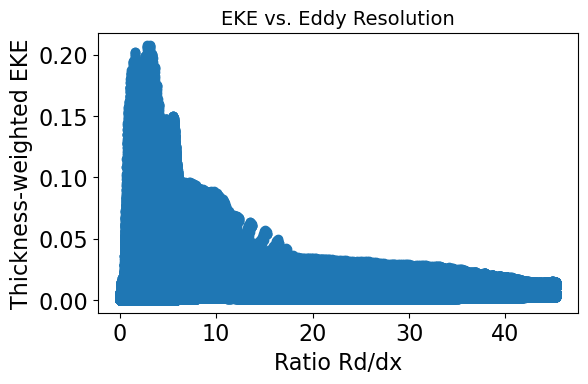

In [116]:
fig = plt.figure(figsize=(8,4), dpi=100, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.6,0.7])

ax1.set_title('EKE vs. Eddy Resolution',fontsize=14)
ax1.set_xlabel('Ratio Rd/dx',fontsize=16)
ax1.set_ylabel('Thickness-weighted EKE',fontsize=16)
ax1.tick_params(labelsize=16); 
ax1.scatter(np.nanmean(Rd_dx,axis=0),EKE_mean)


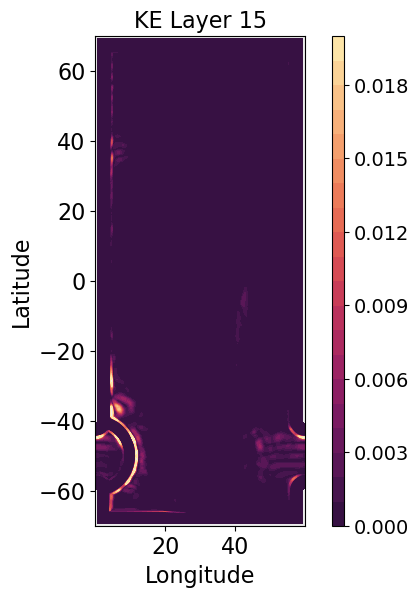

In [48]:
#Plotting KE 
fig = plt.figure(figsize=(4, 7), dpi=100, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.6,0.7]) 
ax2 = fig.add_axes([.78, 0.2, 0.03, 0.7])
ax1.set_facecolor((0.92, 0.92, 0.92))
ax1.set_title('KE Layer 15',fontsize=16)
ax1.set_xlabel('Longitude',fontsize=16)
ax1.set_ylabel('Latitude',fontsize=16)
ax1.tick_params(labelsize=16); 
ax2.tick_params(labelsize=14)

plotted =ax1.contourf(xh,yh,KE[14,:,:],levels=np.linspace(0.,.02,21),cmap=cmocean.cm.matter_r)

ax1.set_aspect('equal', 'box')
cbar = plt.colorbar(mappable=plotted, cax=ax2, orientation = 'vertical');
cbar.ax.tick_params(labelsize=14);
#
plt.show()

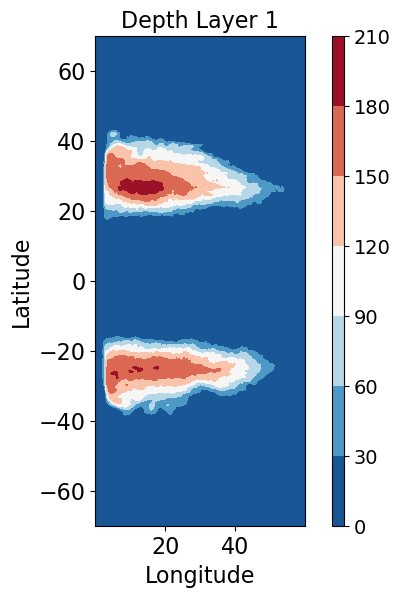

In [51]:
#Plotting eta
fig = plt.figure(figsize=(4, 7), dpi=100, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.6,0.7]) 
ax2 = fig.add_axes([.78, 0.2, 0.03, 0.7])
ax1.set_facecolor((0.92, 0.92, 0.92))
ax1.set_title('Depth Layer 1',fontsize=16)
ax1.set_xlabel('Longitude',fontsize=16)
ax1.set_ylabel('Latitude',fontsize=16)
ax1.tick_params(labelsize=16); 
ax2.tick_params(labelsize=14)

plotted =ax1.contourf(xh,yh,eta[1,:,:],cmap='RdBu_r')

ax1.set_aspect('equal', 'box')
cbar = plt.colorbar(mappable=plotted, cax=ax2, orientation = 'vertical');
cbar.ax.tick_params(labelsize=14);
#
plt.show()

In [67]:
eta.shape

(16, 560, 240)

In [12]:
run

28